In [ ]:
!nvidia-smi

Sun Dec 25 18:18:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |   1760MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Protein')

In [ ]:
from torch.utils.data import DataLoader
from model_builder import BiGRU   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import engine
import torch
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from pathlib import Path
import os



In [ ]:
class Config:

    def __init__(self):
        self.ROOT_PATH = "/content/gdrive/My Drive/Protein/dataset/"
        self.TRAIN_PATH = os.path.join(self.ROOT_PATH, "train/")
        self.VAL_PATH = os.path.join(self.ROOT_PATH, "dev/")
        self.TEST_PATH = os.path.join(self.ROOT_PATH, "test/")
        self.batch_size = 32
        self.number_family = 250

        #Amino Acids most common use
        self.AMINO = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']    

cfg = Config()

class Tools:
    def __init__(self):
        pass

    def create_dict(self, codes):
        self.char_dict = {}
        for index, val in enumerate(codes):
            self.char_dict[val] = index+1

        return self.char_dict

    def read_data(self, data_path ,partition):
        self.data = []
        for fn in os.listdir(os.path.join(data_path, partition)):
            with open(os.path.join(data_path, partition, fn)) as f:
                self.data.append(pd.read_csv(f, index_col=None))
        return pd.concat(self.data)

    def find_common_family(self, thres=250):
        self.df_train = self.read_data(cfg.ROOT_PATH, 'train')
        self.commonLables = self.df_train.family_accession.value_counts()[:thres]

        return self.commonLables


In [ ]:
class DatasetProtein(Dataset):
    def __init__(self, root, split, amino, common_family, encoding="integer", total_sample_size=541, max_size=250, device='cuda'):
        self.root = root
        self.split = split
        self.device = device
        self.max_size = max_size
        self.total_sample_size = total_sample_size
        self.save_path = os.path.join("/content/gdrive/My Drive/Protein/data/", self.split + 'no_categorical_data.pth')
        self.tool = Tools()
        self.amino = amino #lis of common amino acids
        self.data_encode = encoding
        self.common_family=common_family

        if os.path.exists(self.save_path):
            print(f'Loading dataset {self.split} ...')
            self.filtered_data = self.filter_data()
            pth_dataset = torch.load(self.save_path)
            self.data, self.labels = pth_dataset['data'].to(self.device), pth_dataset['label'].to(self.device)
            print(f"Dataset {self.split} loaded !")
        else:
            print(f"File {self.save_path} does not exist. Creating dataset...")  
            self.data, self.labels = self.get_dataset()
            self.data, self.labels = torch.from_numpy(self.data), torch.from_numpy(self.labels)
            data_dict = {"data": self.data, "label": self.labels}
            self.data, self.labels = self.data.to(self.device), self.labels.to(self.device)  
            print(f"Dataset {self.split} created !")
            torch.save(data_dict, self.save_path)
            print(f"File {self.save_path} Saved!")

    def load(self):
        self.data = []
        for fn in os.listdir(os.path.join(self.root, self.split)):
            with open(os.path.join(self.root, self.split, fn)) as f:
                self.data.append(pd.read_csv(f, index_col=None))
        return pd.concat(self.data)

    #filter for most common family on dataset
    def filter_data(self):
        self.df = self.load()
        self.mask = self.df.family_accession.isin(self.common_family.index.values)

        if self.split == 'train':
            self.filter_df = self.df.loc[self.mask,:]
            self.nrows = len(self.filter_df)
            self.filter_df.groupby('family_accession').head()
            self.filter_df = self.filter_df.groupby('family_accession', group_keys=False).apply(lambda x: x.sample(self.total_sample_size))
            self.filter_df = self.filter_df.sample(frac=1).reset_index(drop=True)
        else:
            self.filter_df = self.df.loc[self.mask, :]
        return self.filter_df

    def get_dataset(self):
        encode = LabelEncoder()
        self.filtered_data = self.filter_data()
        self.amino_dict = self.tool.create_dict(self.amino)
        
        if(self.data_encode=='integer'):
            self.encode_list = []
            for row in self.filtered_data['sequence'].values:
                self.row_encode = []
                for code in row:
                    self.row_encode.append(self.amino_dict.get(code, 0))
                self.encode_list.append(np.array(self.row_encode))

            self.data_encoded = pad_sequences(self.encode_list, maxlen=self.max_size, padding='post', truncating='post')
            if self.split=='train':
                self.label_encoded = encode.fit_transform(self.filtered_data['family_accession'])
            else:
                self.label_encoded = encode.fit_transform(self.filtered_data['family_accession'])           
        return self.data_encoded, self.label_encoded

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.filtered_data)

In [ ]:
cfg = Config()
tool = Tools()
common_family = tool.find_common_family()

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)


cuda


In [ ]:
train_ds= DatasetProtein(cfg.ROOT_PATH, 'train', cfg.AMINO, common_family=common_family)
test_ds= DatasetProtein(cfg.ROOT_PATH, 'test', cfg.AMINO, common_family=common_family)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Loading dataset train ...
Dataset train loaded !
Loading dataset test ...
Dataset test loaded !


In [ ]:
model = BiGRU(num_embedding=len(cfg.AMINO)+1, output_size=cfg.number_family, embedding_dim=cfg.number_family, hidden_dim=128, n_layers=2)
model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

result = engine.train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=100,
    device="cuda"
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2140 | train_acc: 0.0555 | test_loss: 3.5061 | test_acc: 0.1267
Epoch: 2 | train_loss: 3.2096 | train_acc: 0.1777 | test_loss: 2.9408 | test_acc: 0.2290
Epoch: 3 | train_loss: 2.7269 | train_acc: 0.2972 | test_loss: 2.5086 | test_acc: 0.3471
Epoch: 4 | train_loss: 2.3225 | train_acc: 0.3988 | test_loss: 2.1650 | test_acc: 0.4262
Epoch: 5 | train_loss: 1.9524 | train_acc: 0.4910 | test_loss: 1.7642 | test_acc: 0.5392
Epoch: 6 | train_loss: 1.5644 | train_acc: 0.5965 | test_loss: 1.4092 | test_acc: 0.6278
Epoch: 7 | train_loss: 1.2380 | train_acc: 0.6856 | test_loss: 1.1095 | test_acc: 0.7162
Epoch: 8 | train_loss: 0.9801 | train_acc: 0.7533 | test_loss: 0.8694 | test_acc: 0.7757
Epoch: 9 | train_loss: 0.7923 | train_acc: 0.7996 | test_loss: 0.6930 | test_acc: 0.8220
Epoch: 10 | train_loss: 0.6382 | train_acc: 0.8402 | test_loss: 0.5587 | test_acc: 0.8560
Epoch: 11 | train_loss: 0.5250 | train_acc: 0.8671 | test_loss: 0.4592 | test_acc: 0.8817
Epoch: 12 | train_l

In [ ]:
import matplotlib.pyplot as plt

def plot_history(result):
  acc = result['train_acc']
  val_acc = result['test_acc']
  loss = result['train_loss']
  val_loss = result['test_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

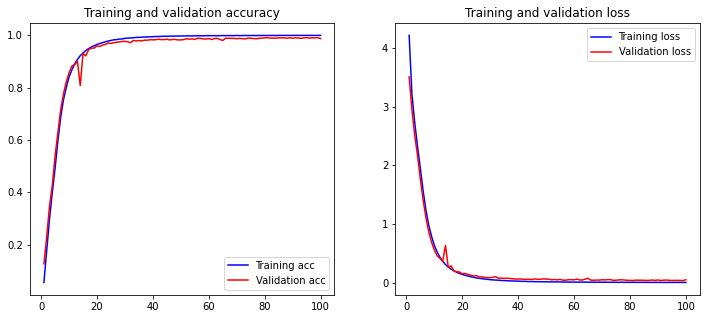

In [ ]:
plot_history(result)

In [ ]:
torch.save(obj=model.state_dict(), f='/content/gdrive/My Drive/Protein/model/protein_BiGRU.pth')